In [2]:
#1
import os
import cv2
import warnings
import numpy as np
import pandas as pd
import sklearn.metrics.pairwise as pairwise
!pip install insightface
!pip install onnxruntime
!pip install onnxruntime-gpu==1.15.1 # Install onnxruntime-gpu (if using GPU)
warnings.filterwarnings('ignore')  # Ignore all warnings


from insightface.app import FaceAnalysis


# configure face analysis
faceapp = FaceAnalysis(name='antelopev2',
                       root='insightface_model',
                       providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])

faceapp.prepare(ctx_id=0, det_size=(640,640), det_thresh=0.5)
# warning: don't set det_thresh < 0.3

# Load the NPZ file
file_np = np.load('dataframe_antelopev2.npz', allow_pickle=True)
dataframe = pd.DataFrame(file_np['arr_0'], columns=file_np['arr_1'])


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: insightface_model/models/antelopev2/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: insightface_model/models/antelopev2/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: insightface_model/models/antelopev2/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: insightface_model/models/antelopev2/glintr100.onnx recognition ['None', 3, 112, 112] 127.5 127.5
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: insightface_model/models/antelopev2/scrfd_10g_bnkps.onnx detection [1, 3, '?', '?'] 127.5 128.0
set det-size: (640, 640)


In [3]:

#2
def ml_search_algorithm(dataframe,feature_column,test_vector,
                        name=['Name'],thresh=0.5):
    """
    cosine similarity base search algorithm
    """
    # step-1: take the dataframe (collection of data)
    dataframe = dataframe.copy()
    # step-2: Index face embeding from the dataframe and convert into array
    X_list = dataframe[feature_column].tolist()
    x = np.asarray(X_list)

    # step-3: Cal. cosine similarity
    similar = pairwise.cosine_similarity(x,test_vector.reshape(1,-1))
    similar_arr = np.array(similar).flatten()
    dataframe['cosine'] = similar_arr

    # step-4: filter the data
    data_filter = dataframe.query(f'cosine >= {thresh}')
    if len(data_filter) > 0:
        # step-5: get the person name
        data_filter.reset_index(drop=True,inplace=True)
        argmax = data_filter['cosine'].argmax()
        person_name = data_filter.loc[argmax][name]

    else:
        person_name = 'Unknown'
        # person_role = 'Unknown'

    return person_name


In [4]:
# prompt: drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
print(dataframe)

          Name                                    Facial_Features
0   2020331001  [0.7204848, -0.9006118, -1.0924181, 0.2334579,...
1   2020331001  [-1.243562, 0.35026276, -0.35382187, -0.447032...
2   2020331001  [-1.7163537, 0.023880064, 0.42466462, -0.54959...
3   2020331001  [-1.2192954, 0.804762, 0.06255894, -0.57922435...
4   2020331001  [-0.50267076, 0.04696849, -0.18810587, -0.4829...
..         ...                                                ...
80  2020331023  [-0.9169077, -0.5589326, -1.5067997, -0.313452...
81  2020331023  [0.05124008, -0.6279136, -1.6636531, 0.3063531...
82  2020331023  [-0.0036960915, -0.30887508, -1.9240712, -0.42...
83  2020331023  [-0.8126801, 0.00026284158, -1.6124132, 0.2507...
84  2020331023  [-2.0881364, -0.16832109, -1.5583168, -1.62636...

[85 rows x 2 columns]


In [6]:
from google.colab.patches import cv2_imshow


In [ ]:
#3(for multiple test images)

pth = '/content/drive/MyDrive/pixx'
img_files = os.listdir(path = pth)
for file in img_files:
    path = f'/content/drive/MyDrive/pixx/{file}'
    test_image = cv2.imread(path)
    cv2_imshow(test_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    results = faceapp.get(test_image)

    # step-2: use for loop and extract each embedding and pass to ml_search_algorithm
    identified_names = []
    for res in results:
        embeddings = res['embedding']
        person_name = ml_search_algorithm(dataframe,  # No need for person_role
                                          'Facial_Features',
                                          test_vector=embeddings,
                                          name=['Name'],
                                          thresh=0.5)
        # print(str(person_name))
        if isinstance(person_name, pd.Series):
            # Extract the name as a string from the Series
            name_str = person_name.values[0]  # or person_name.iloc[0]
        else:
            # If it's already a string, use it directly
            name_str = person_name

        # Append to the list
        if name_str!= "Unknown":
            identified_names.append(name_str)



    print(identified_names)
# print("       ")
    # print(person_name) # Just print the name

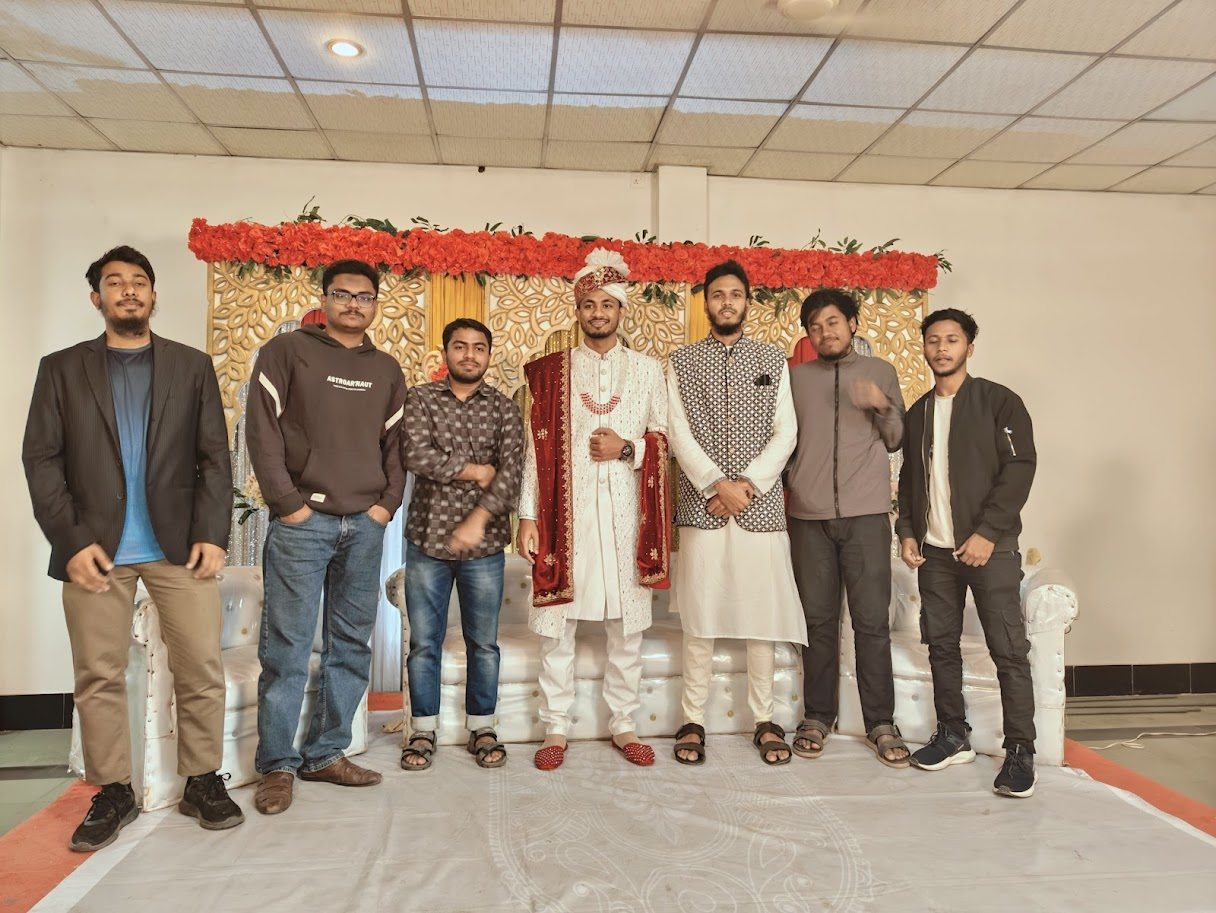

['2020331017', '2020331067', '2020331001', '2020331097']


In [14]:

#3
# step-1: take the test image and apply to insight face
# test_image =  cv2.imread('/content/drive/MyDrive/A.0/2_Fast_Face_Recognition_System/test_images/IMG-20240602-WA0018.jpg')
pth = '/content/drive/MyDrive/A.0/2_Fast_Face_Recognition_System/test_images/IMG20250124160927.jpg'
test_image = cv2.imread(pth)
# test_image = cv2.imread('/content/drive/MyDrive/A.0/2_Fast_Face_Recognition_System/test_image_1.jpg')
cv2_imshow(test_image)
cv2.waitKey(0)
cv2.destroyAllWindows()
results = faceapp.get(test_image)

# step-2: use for loop and extract each embedding and pass to ml_search_algorithm
identified_names = []
for res in results:
    embeddings = res['embedding']
    person_name = ml_search_algorithm(dataframe,  # No need for person_role
                                       'Facial_Features',
                                       test_vector=embeddings,
                                       name=['Name'],
                                       thresh=0.5)
    # print(str(person_name))
    if isinstance(person_name, pd.Series):
        # Extract the name as a string from the Series
        name_str = person_name.values[0]  # or person_name.iloc[0]
    else:
        # If it's already a string, use it directly
        name_str = person_name

    # Append to the list
    if name_str!= "Unknown":
        identified_names.append(name_str)



print(identified_names)
# print("       ")
    # print(person_name) # Just print the name